In [40]:
import os
import re
import numpy as np
import pandas as pd
from pprint import pprint
from itertools import groupby

# reading docfiles
import docx2txt

# nltk
import nltk

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

# textblob
from textblob_de import TextBlobDE

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

# alternative sentiment model
from germansentiment import SentimentModel
model = SentimentModel()

In [41]:
df = pd.read_excel("input/app_v2/app_v2_feedback.xlsx")

In [42]:
df['text_processed'] = pd.Series(np.zeros(df.shape[0]))
df.loc[df['context'].isna(), 'text_processed'] = df['text']
df.loc[df['context'].notna(), 'text_processed'] = df['text'] + df['context']

In [43]:
df.head()

,transcript_id,person_id,segment_id,context,lesson,text,category_id,text_processed
0,tn_01,p01,s_001,NaN,NaN,"Ja, ich höre Sie ein bisschen schlecht. Das ha...",2,"Ja, ich höre Sie ein bisschen schlecht. Das ha..."
1,tn_01,p01,s_002,NaN,NaN,"Ja, jetzt ist es ein bisschen besser. Ja.",2,"Ja, jetzt ist es ein bisschen besser. Ja."
2,tn_01,p01,s_003,"Ok, gut. Also… Ich habe jetzt das Aufnahmeger...",NaN,Ok. Ja.,1,"Ok. Ja. Ok, gut. Also… Ich habe jetzt das Aufn..."
3,tn_01,p01,s_004,NaN,NaN,"So ein Diktiergerät quasi. Ja, ja. Mhm.",2,"So ein Diktiergerät quasi. Ja, ja. Mhm."
4,tn_01,p01,s_005,Und ich spreche Sie jetzt auch nicht mit dem N...,NaN,"Ok, dann machen wir das so. Ja!",1,"Ok, dann machen wir das so. Ja!Und ich spreche..."


In [44]:
app_comments = df[df["category_id"].isin([9, 10, 11])]

In [45]:
app_comments = app_comments.drop(columns=['transcript_id', 'person_id', 'segment_id', 'context', 'lesson', 'category_id', 'text'], 
             axis = 1)

In [46]:
app_comments_list = app_comments.text_processed.values.tolist()

In [47]:
sentiment_v = []
sentiment_p = []
for i in range(0, len(app_comments_list)-1):
    text_extract = app_comments_list[i]
    blob = TextBlobDE(text_extract)
    sentiment = blob.sentiment
    sentiment_p.append(sentiment.polarity)
    if 0 < sentiment.polarity < 0.5:
        sentiment_v.append('positive')
    if sentiment.polarity >= 0.5:
        sentiment_v.append('very positive')
    if -0.5 < sentiment.polarity < 0:
        sentiment_v.append('negative')
    elif sentiment.polarity <= -0.5:
        sentiment_v.append('very negative')
    else: 
        sentiment_v.append('neutral')

In [48]:
# This is a list of unique values appearing in the input list
# automatic method
# sentiment_v_unique = list(set(sentiment_v))
sentiment_v_unique = ['very negative', 'negative', 'neutral', 'positive', 'very positive']

In [49]:
# This is the corresponding count for each value
counts = [sentiment_v.count(value) for value in sentiment_v_unique]

In [50]:
proportions = [(x/sum(counts))*100 for x in counts]

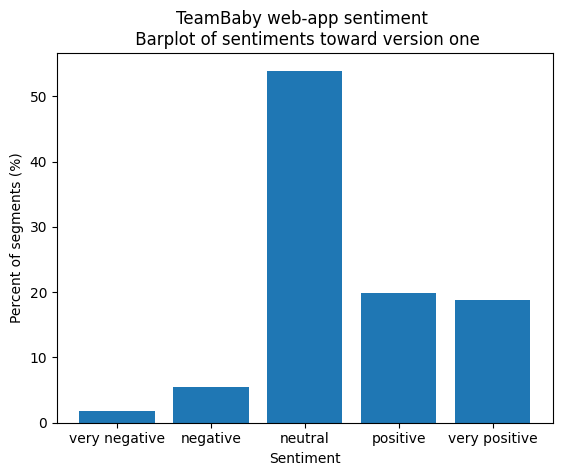

In [51]:
barcontainer = plt.bar(range(len(sentiment_v_unique)), proportions)

# Some labels and formatting to look more like the example
plt.xticks([0, 1, 2, 3, 4], sentiment_v_unique) 
plt.title("TeamBaby web-app sentiment \n Barplot of sentiments toward version one")
plt.ylabel("Percent of segments (%)")
plt.xlabel("Sentiment")
plt.savefig('output/app_v1_sentiment.png')

In [52]:
sentiment_p = []
for i in range(0, len(app_comments_list)-1):
    text_extract = app_comments_list[i]
    blob = TextBlobDE(text_extract)
    sentiment_p.append(blob.sentiment.polarity)

In [53]:
sentiment_p_df = pd.DataFrame(sentiment_p, columns =['app_v2_polarity'])

sentiment_p_df.to_csv('output/app_v2_polarity.csv', index=False)

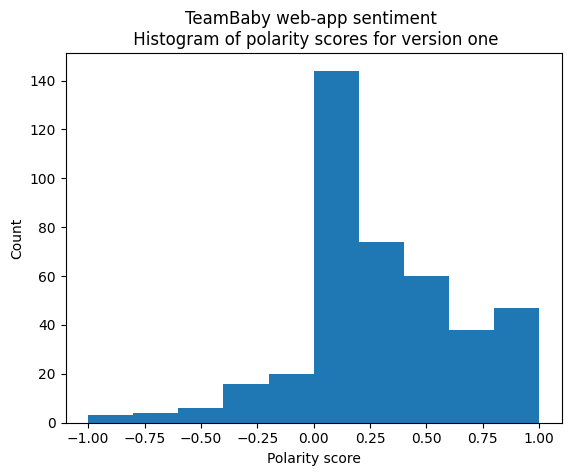

In [54]:
plt.hist(sentiment_p)

# Some labels and formatting to look more like the example
plt.title("TeamBaby web-app sentiment \n Histogram of polarity scores for version one")
plt.ylabel("Count")
plt.xlabel("Polarity score")
plt.savefig('output/app_v1_polarity.png')

In [55]:
# Python program to get average of a list
def Average(lst):
    return sum(lst) / len(lst)

In [56]:
# Printing average of the list
average = Average(sentiment_p)
print("Average sentiment =", round(average, 2))

Average sentiment = 0.27


In [ ]:
sentiment_n = []
for i in range(0, len(app_comments_list)-1):
    text_extract = app_comments_list[i]
    result = model.predict_sentiment(text_extract)
    sentiment_n.append(result)

In [97]:
sentiment_v_unique = list(set(sentiment_n[1]))

In [98]:
# This is the corresponding count for each value
counts = [sentiment_n[1].count(value) for value in sentiment_v_unique]

In [99]:
proportions = [(x/sum(counts))*100 for x in counts]

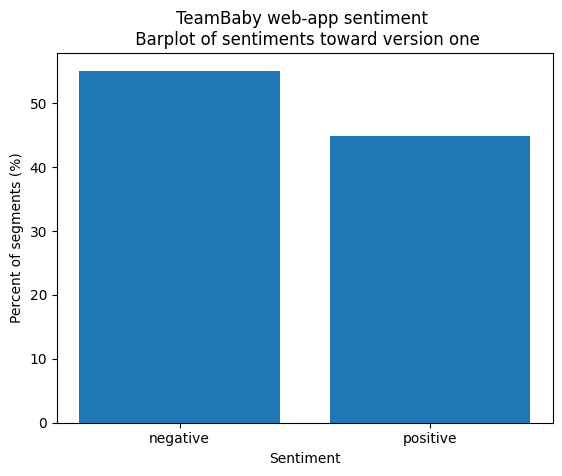

In [101]:
barcontainer = plt.bar(range(len(sentiment_v_unique)), proportions)

# Some labels and formatting to look more like the example
plt.xticks([0, 1], sentiment_v_unique) 
plt.title("TeamBaby web-app sentiment \n Barplot of sentiments toward version one")
plt.ylabel("Percent of segments (%)")
plt.xlabel("Sentiment")
plt.savefig('output/app_v1_sentiment.png')

In [57]:
df = []
for i in range(len(app_comments_list)):
    sentence = nltk.tokenize.sent_tokenize(app_comments_list[i])
    for i in range(len(sentence)):
        df.append(sentence[i])

In [58]:
sentiment_v = []
sentiment_p = []
for i in range(0, len(df)-1):
    text_extract = df[i]
    blob = TextBlobDE(text_extract)
    sentiment = blob.sentiment
    sentiment_p.append(sentiment.polarity)
    if sentiment.polarity > 0:
        sentiment_v.append('positive')
    elif sentiment.polarity < 0:
        sentiment_v.append('negative')
    else: 
        sentiment_v.append('neutral')

In [59]:
# This is a list of unique values appearing in the input list
# automatic method
# sentiment_v_unique = list(set(sentiment_v))
sentiment_v_unique = ['negative', 'neutral', 'positive']

In [60]:
# This is the corresponding count for each value
counts = [sentiment_v.count(value) for value in sentiment_v_unique]

In [61]:
proportions = [(x/sum(counts))*100 for x in counts]

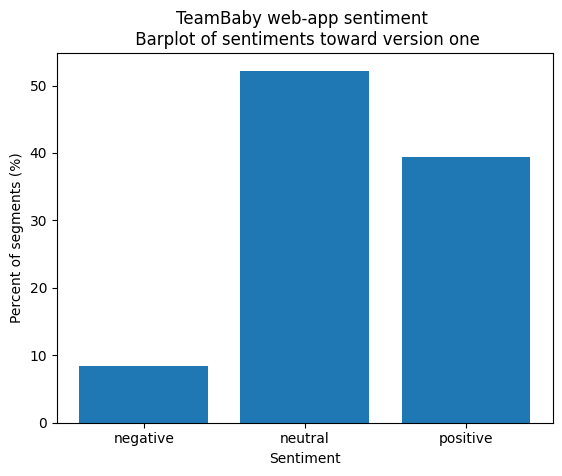

In [62]:
barcontainer = plt.bar(range(len(sentiment_v_unique)), proportions)

# Some labels and formatting to look more like the example
plt.xticks([0, 1, 2], sentiment_v_unique) 
plt.title("TeamBaby web-app sentiment \n Barplot of sentiments toward version one")
plt.ylabel("Percent of segments (%)")
plt.xlabel("Sentiment")
plt.savefig('output/app_v1_sentiment.png')

In [63]:
# Printing average of the list
average = Average(sentiment_p)
print("Average sentiment =", round(average, 2))

Average sentiment = 0.25


In [64]:
sentiment_p_df = pd.DataFrame(sentiment_p, columns =['app_v2_polarity'])

sentiment_p_df.to_csv('output/app_v2_polarity.csv', index=False)

In [65]:
sentiment_count_df = pd.DataFrame(
    {'sentiment': sentiment_v_unique, 
     'count': counts
    })

sentiment_count_df.to_csv('output/app_v2_sentiment_count_df.csv', index=False)